In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nbodykit.lab import *
from nbodykit import style, setup_logging
import matplotlib.pyplot as plt
plt.style.use(style.notebook)
import gc
import pandas as pd
import nbodykit as nb
from nbodykit.lab import ArrayCatalog 

In [2]:
data_read = pd.read_csv('./Ne_Galaxy_Mstar10_ver2.csv')

In [3]:
data_jk_o = data_read[['X','Y','Z','Vx','Vy','Vz','Mass']]
data_jk = np.array(data_jk_o)

In [4]:
struct_dtype = np.dtype([
    ('Pos', np.float32, 3),
    ('Vel', np.float32, 3),
    ('CentralMvir', np.float32),
])
jk_struct = np.empty(data_jk.shape[0], dtype=struct_dtype)

jk_struct['Pos']         = data_jk[:, 0:3]
jk_struct['Vel']         = data_jk[:, 3:6]
jk_struct['CentralMvir'] = data_jk[:, 6]

In [5]:

#const
LOS=[1,0,0]
z_eff=0

#cos
cosmo = cosmology.Planck15
H=cosmo.efunc(z_eff)*100
a=1/(1+z_eff)
def RED(cat):
    line_of_sight_x=(1,0,0)
    cat['vel_x']=cat['Vel']*line_of_sight_x/(a*H)

    cat['RsdPos_x']=cat['Pos']+(cat['vel_x']*line_of_sight_x)
    cat['Vx'] = cat['Vel'][:,0]
    return cat

In [6]:
jk_np = jk_struct
min_mvir = 3 
mask = jk_struct['CentralMvir'] > 10**min_mvir
jk_np = jk_np[mask]
jk_struct = nb.source.catalog.ArrayCatalog(jk_np)

In [7]:
print(jk_np.shape)

(4553,)


In [8]:
def momentum_00(cat,BoxSize=200):
    LOS = [1,0,0]
    cat['Vx'] = (cat['Vel'] @ LOS) 
    mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='RsdPos_x')
    r00 = FFTPower(mesh, mode='1d', los=[1,0,0])
    P00 = r00.power['power'].real - r00.attrs['shotnoise']
    return r00, P00
def momentum(cat,BoxSize=200):
    LOS = [1,0,0]
    cat['Vx'] = (cat['Vel'] @ LOS) 
    momentum_mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='RsdPos_x', value='Vx')
    mesh = cat.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='RsdPos_x')
    r01 = FFTPower(momentum_mesh, mode='1d', poles=[1], second=mesh, los=LOS)
    P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag
    return r01, P01

In [9]:
jk_struct = RED(jk_struct)

cat_all = jk_struct 
BoxSize = 205         
nside   = (8, 8, 8)              
LOS_vec = np.array([1, 0, 0], dtype=np.float32)

In [10]:
momentum_mesh_test = jk_struct.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='RsdPos_x', value='Vx')
mesh_test = jk_struct.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='RsdPos_x')
print(type(momentum_mesh_test))

<class 'nbodykit.source.mesh.catalog.CatalogMesh'>


In [11]:
r_full, P_full = momentum_00(cat_all, BoxSize=BoxSize)
k_mid = r_full.power['k']
Nk    = k_mid.size
B = 512
P_mesh_blocks_l_0 = np.empty((B, Nk), dtype=np.float32)
P_mesh_blocks_l_2 = np.empty((B, Nk), dtype=np.float32)
P_mesh_blocks_l_4 = np.empty((B, Nk), dtype=np.float32)

r_full_momentum, P_full_momentum = momentum(cat_all, BoxSize=BoxSize)
k_mid_momentum = r_full_momentum.poles['k']
Nk_momentum = k_mid_momentum.size
P_momentum_block = np.empty((B,Nk_momentum), dtype=np.float32)

In [12]:
step = 32
field_momentum = momentum_mesh_test.to_field()
value_momentum = field_momentum.value
field_mesh = mesh_test.to_field()
value_mesh = field_mesh.value
b = 0
LOS=[1,0,0]


for i in range(8):
    for j in range(8):
        for k in range(8):
            slc = (slice(i*step,(i+1)*step),
                   slice(j*step,(j+1)*step),
                   slice(k*step,(k+1)*step))
            
            backup_momentum = value_momentum[slc].copy()
            backup_mesh = value_mesh[slc].copy()
            value_momentum[slc] = 0
            value_mesh[slc] = 0
            
            r01 = FFTPower(field_momentum, mode='1d', poles=[1], second=field_mesh, los=LOS)
            P01 = 2 * r01.poles['k'] * r01.poles['power_1'].imag
            r00 = FFTPower(field_mesh, mode='1d', poles=[0,2,4], los=[1,0,0])
            

            P00_l_0 = r00.poles['power_0'].real - r00.attrs['shotnoise']
            P_mesh_blocks_l_0[b] = P00_l_0
            P00_l_2 = r00.poles['power_2'].real
            P_mesh_blocks_l_2[b] = P00_l_2
            P00_l_4 = r00.poles['power_4'].real
            P_mesh_blocks_l_4[b] = P00_l_4

        
            P_momentum_block[b] = P01
            b += 1
            value_momentum[slc] = backup_momentum
            value_mesh[slc] = backup_mesh

In [13]:
P_mesh = {0:P_mesh_blocks_l_0, 2:P_mesh_blocks_l_2, 4:P_mesh_blocks_l_4}
cov_00_01 = {}
cov_00 = {}

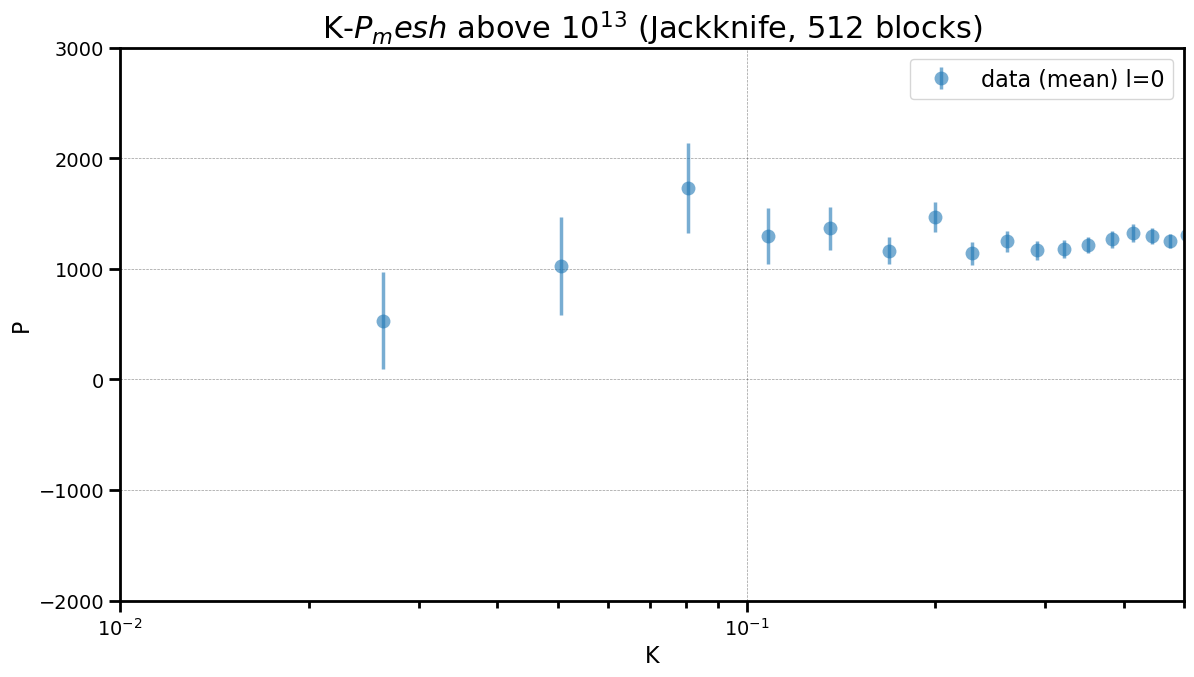

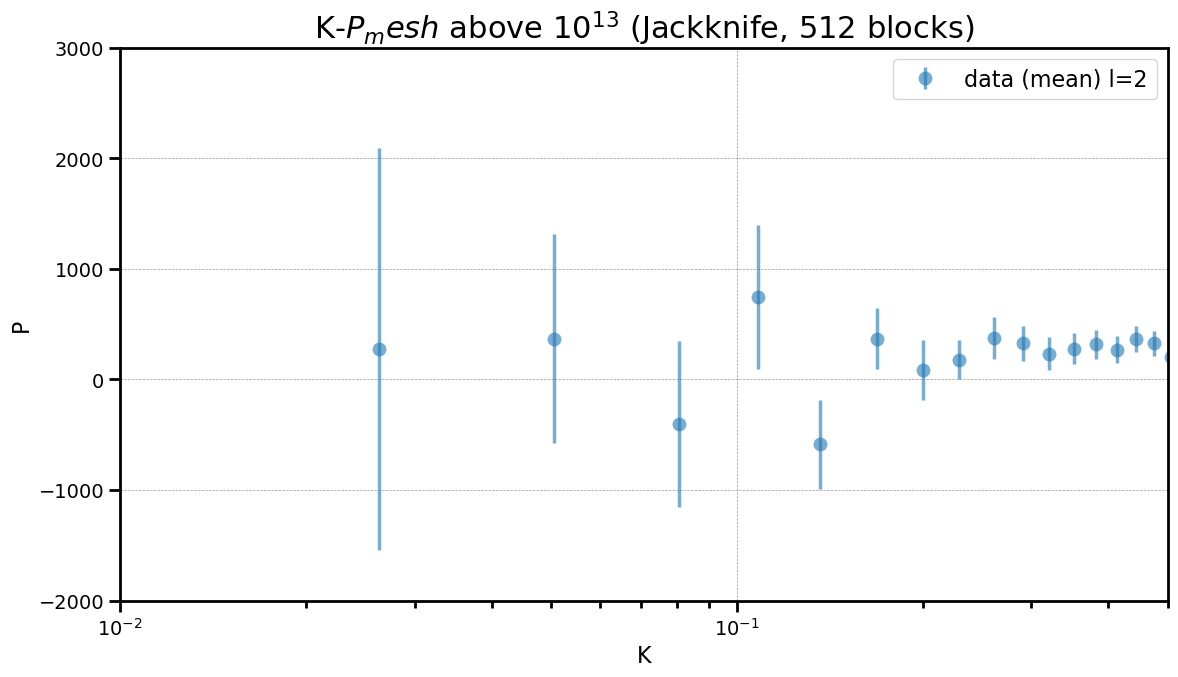

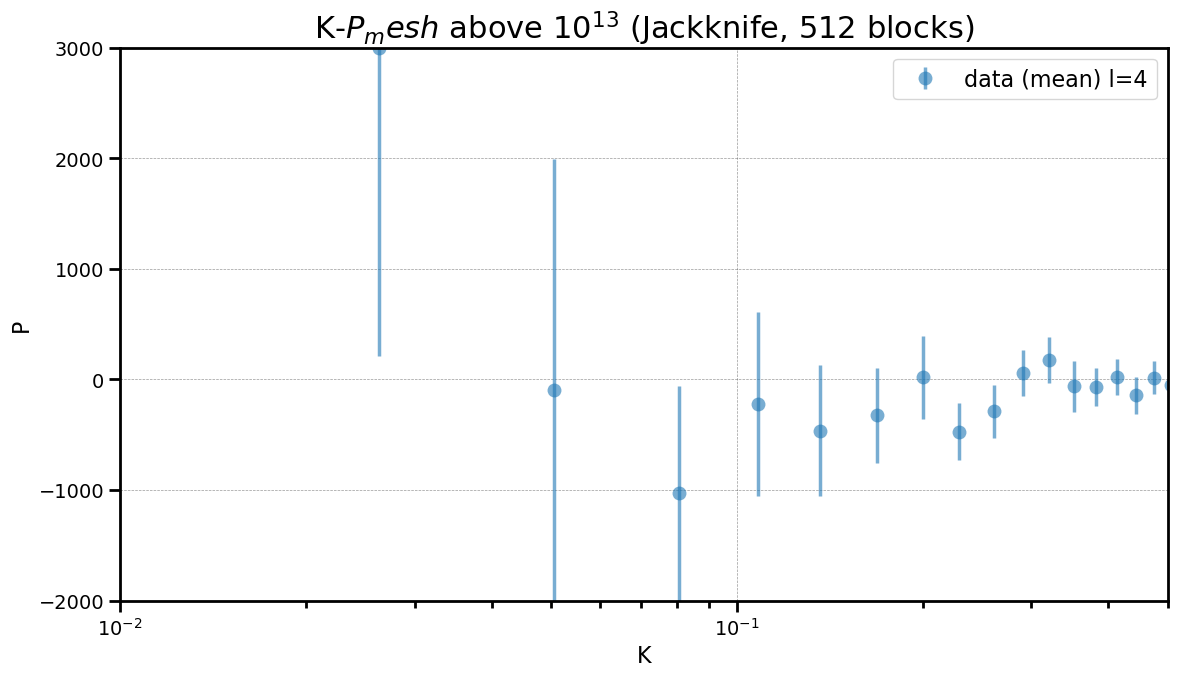

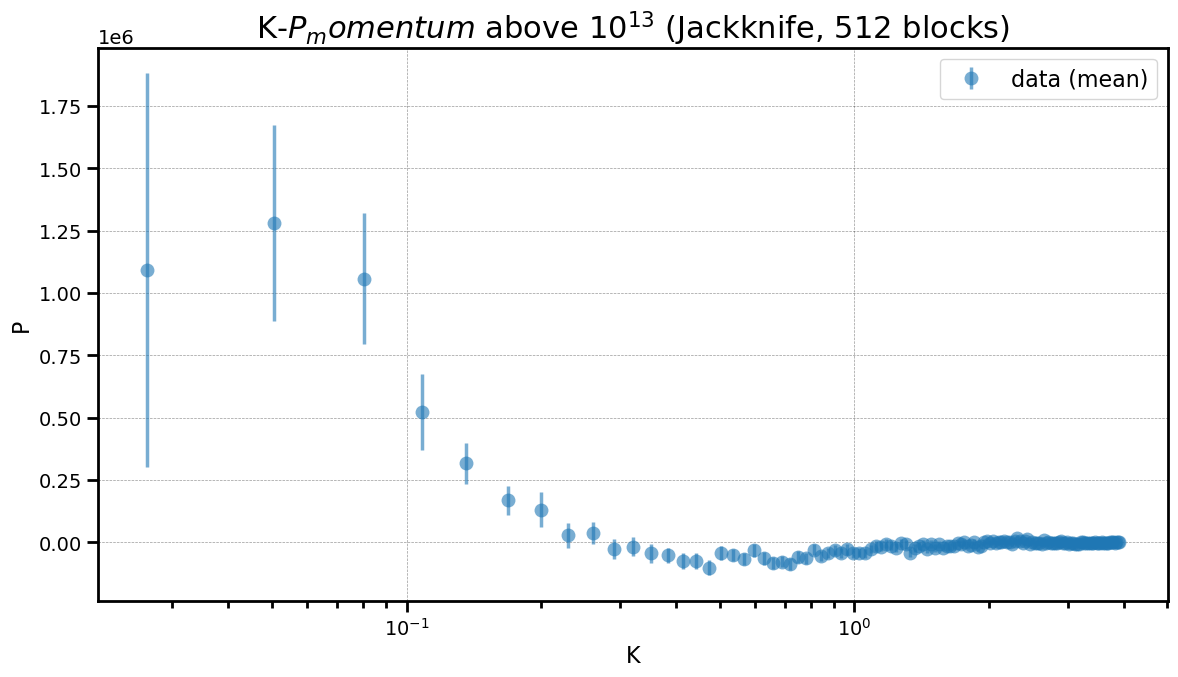

In [14]:
P_momentum_mean = P_momentum_block.mean(axis=0)
diff_momentum   = P_momentum_block - P_momentum_mean

for ell in [0,2,4]:  
    P_mesh_blocks = P_mesh[ell]
    P_mesh_mean = P_mesh_blocks.mean(axis=0)
    diff_mesh   = P_mesh_blocks - P_mesh_mean
    cov_all_jk = (B - 1) / B * diff_mesh.T @ diff_momentum   
    cov_mesh_jk = (B - 1) / B * diff_mesh.T @ diff_mesh 
    var_mesh_jk = np.diag(cov_mesh_jk)                
    sigma_mesh  = np.sqrt(var_mesh_jk)

    cov_00_01[ell] = cov_all_jk
    cov_00[ell] = cov_mesh_jk


    plt.figure()
    # idx_skip = 0
    # idx_skip_2 = 0                
    # mask = (np.arange(k_mid.size) != idx_skip) & idx_skip_2
    plt.errorbar(k_mid, k_mid*P_mesh_mean, yerr=sigma_mesh*k_mid,
                fmt='o', capsize=3, alpha=0.6,
                label=f'data (mean) l={ell}')

    plt.xscale('log')
    plt.xlabel('K')
    plt.ylabel('P')
    plt.title(fr'K-$P_mesh$ above $10^{{{10+min_mvir}}}$ (Jackknife, 512 blocks)')
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.ylim(-2000,3000)
    plt.xlim(0.01, 0.5)
    plt.show()


cov_momentum_jk = (B - 1) / B * diff_momentum.T @ diff_momentum 
var_momentum_jk = np.diag(cov_momentum_jk)                
sigma_momentum  = np.sqrt(var_momentum_jk)
plt.figure()
# idx_skip = 0
# idx_skip_2 = 0                
# mask = (np.arange(k_mid.size) != idx_skip) & idx_skip_2
plt.errorbar(k_mid_momentum, P_momentum_mean, yerr=sigma_momentum,
            fmt='o', capsize=3, alpha=0.6,
            label='data (mean)')

plt.xscale('log')
plt.xlabel('K')
plt.ylabel('P')
plt.title(fr'K-$P_momentum$ above $10^{{{10+min_mvir}}}$ (Jackknife, 512 blocks)')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.legend()
plt.show()


In [15]:
import h5py
with h5py.File('covariance.h5', 'w') as f:
    f['cov_01'] = cov_momentum_jk
    f['mesh_r00'] = k_mid
    f['momentum_P01'] = P_momentum_mean
    f['mesh_r01'] = k_mid_momentum

    grp_cov_00_01 = f.create_group('cov_00_01')
    for ell, arr in cov_00_01.items():
        grp_cov_00_01[str(ell)] = np.array(arr)
    grp_cov_00 = f.create_group('cov_00')
    for ell, arr in cov_00.items():
        grp_cov_00[str(ell)] = np.array(arr)
    grp_mesh = f.create_group('mesh_P00')
    for ell, arr in P_mesh.items():
        grp_mesh[str(ell)] = np.array(arr)


In [16]:
mesh_00_test = cat_all.to_mesh(interlaced=True,compensated=True, Nmesh=256, BoxSize=BoxSize, resampler='tsc', position='RsdPos_x')
mesh_r00_test_0 = FFTPower(mesh_00_test, mode='1d', poles=[0,2,4], los=[1,0,0])
mesh_r00_test = mesh_r00_test_0.poles
mesh_P00_test_l_0 = mesh_r00_test['power_0'].real - mesh_r00_test_0.attrs['shotnoise']
mesh_P00_test_l_2 = mesh_r00_test['power_2'].real
mesh_P00_test_l_4 = mesh_r00_test['power_4'].real

(0.01, 0.5)

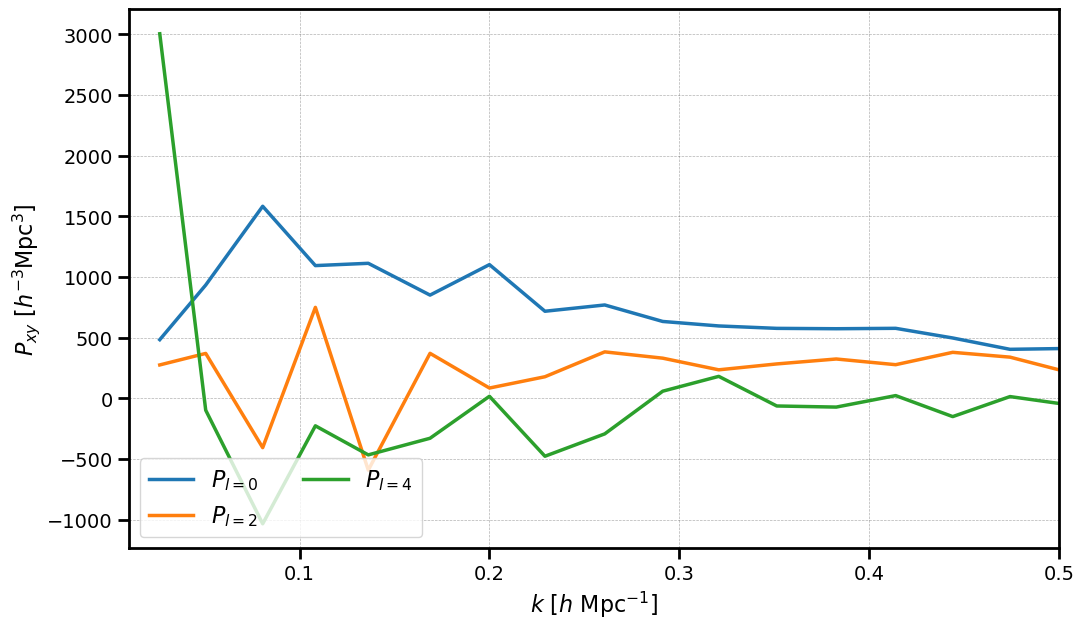

In [17]:
# P00
plt.loglog(mesh_r00_test['k'], mesh_r00_test['k']*mesh_P00_test_l_0, label=r'$P_{l=0}$')

# P01
plt.loglog(mesh_r00_test['k'], mesh_r00_test['k']*mesh_P00_test_l_2, label=r"$P_{l=2}$")

# P11
plt.loglog(mesh_r00_test['k'], mesh_r00_test['k']*mesh_P00_test_l_4, label=r"$P_{l=4}$")

# format the axes
plt.legend(loc='lower left', ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P_{xy}$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(0.01, 0.5)
# plt.ylim(-2e4, 4e4)